In [305]:
# Import necessary packages
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.cuda.device_count()  # print 1
import torchdeepretina as tdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchdeepretina.io as tdrio
import torchdeepretina.utils as tdrutils
import stimuli as s
import torchdeepretina.stimuli as tdrstim
from tqdm import tqdm
from itertools import repeat
from matplotlib import ticker, cm
from colormap import Colormap
c = Colormap()
mycmap = c.cmap_linear('#2378FF','#FFFFFF','#FF3C3C')

In [306]:
device = torch.device("cuda:0")
# load model given path
def load_model(model_path):
    """
    in: model_path
    out: model
    """
    model = tdrio.load_model(model_path)
    model.to(device)
    model.eval()
    return model

In [307]:
model_dir_path = '/home/htanaka/torch-deep-retina/models_paper/'#/tanaka/convgc_models/gcchansearch_57_chans[4, 4]/'
#model_n_path = '15-11-21b_naturalscene'
model_n_path = 'convgc_15-11-21b_naturalscene'
#model_n_path = '15-10-07_naturalscene'
#model_n_path = 'convgc_15-10-07_naturalscene'

model_n = load_model(model_dir_path + model_n_path + '.pt')
model_n = tdr.utils.stacked2conv(model_n)

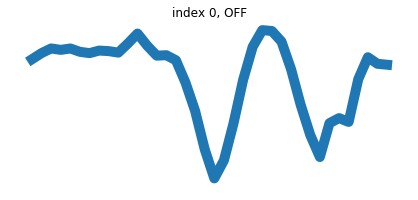

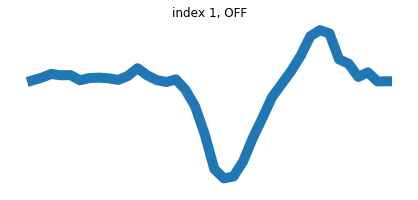

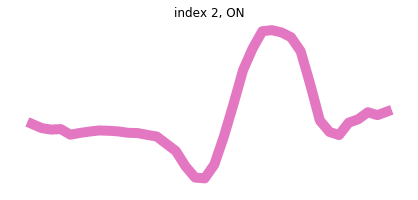

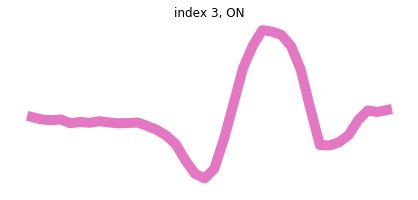

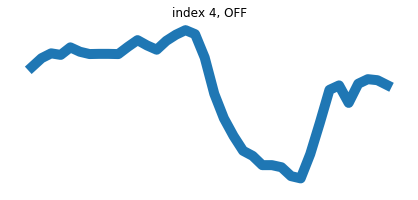

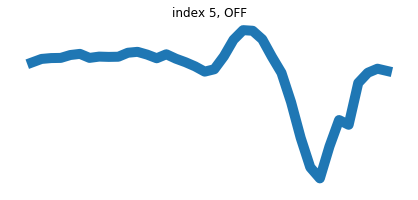

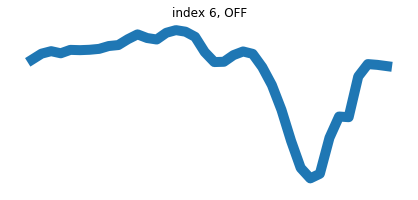

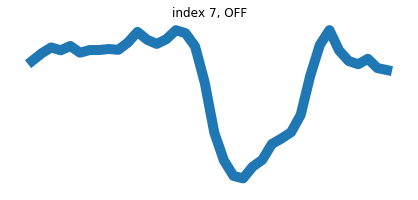

In [295]:
# Analysis
on_off = np.zeros(8)
for i in range(8):
    
    fig, ax = plt.subplots(1, 1, figsize=(7,3))
    # Set line width of axes
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.spines["left"].set_linewidth(0)

    # Turn on/off axes, ticks, change width, labelsize
    ax.tick_params(axis="both", which="both", bottom=False, top=False,
                   labelbottom=False, left=False, right=False,
                   labelleft=False,direction='out',length=7,width=1.0,pad=8,labelsize=20)

    
    filter_3 = torch.sum(model_n.sequential[0].weight[i],(1,2)).cpu().detach().numpy()
    amax = 15+ np.argmax( np.abs(filter_3[15:]))

    #plt.scatter(amax, filter_3[amax])
    
    on_off[i] = np.sign(filter_3[amax])
    if on_off[i]>0:
        plt.title('index '+str(i)+', ON')
        plt.plot(filter_3[2:], lw=10, c=plt.cm.tab10(6))
    else:
        plt.title('index '+str(i)+', OFF')
        plt.plot(filter_3[2:], lw=10, c=plt.cm.tab10(0))
        
    #plt.tight_layout()
    #plt.savefig('./Journal_Figures/filter_cell'+str(i)+'.pdf')
    plt.show()

In [308]:
# OSR
def OSR(period):
    duration = 100
    x_=np.zeros([duration+40,50,50])
    idxs =(89-np.arange(0,90, period))[::-1]
    indices = np.sort(np.concatenate([idxs, idxs+1]))
    x_[indices]-=2
    x=np.zeros([duration,40,50,50])
    for i in range(duration):
        x[i]=x_[i:i+40]
    return x
x = OSR(10)

In [309]:
# Data generation

periods = np.arange(2,9)
integ_steps = 100

n_chans = model_n.n_units


for j in range( n_chans ):
    for i in range( len(periods) ):
        x = OSR(periods[i])
        integrad, response = tdrutils.integrated_gradient(model=model_n, X=x, layer="sequential.0", chans=j, alpha_steps=integ_steps)
        integrad, resopnse = integrad.numpy(), response.numpy()

        outfile_integrad = './analysis_data/'+model_n_path+'/osr/integrad_chan_'+str(j)+'_period_'+str(periods[i])+'_steps_'+str(integ_steps)+'.npy'
        outfile_response = './analysis_data/'+model_n_path+'/osr/response_chan_'+str(j)+'_period_'+str(periods[i])+'_steps_'+str(integ_steps)+'.npy'
        np.save(outfile_response, response)
        np.save(outfile_integrad, integrad)

KeyboardInterrupt: 

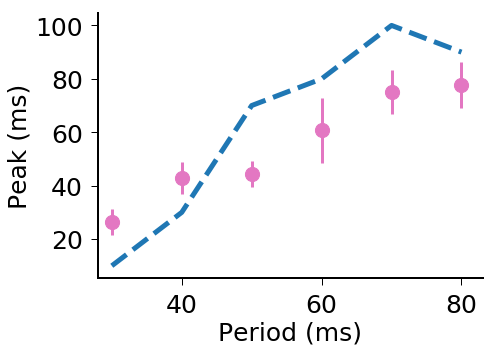

In [489]:
#model_n_path = 'convgc_15-11-21b_naturalscene'
#model_n_path = 'convgc_15-10-07_naturalscene'
n_chans = model_n.n_units
osr_cells = [0,1,2,5,6,7,8,9,10,11,12,14,15,16]#[0,1,2,5,6,7,8,9,10,11,12,14,15,16]
max_pos = np.zeros([len(osr_cells),len(periods)])





fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(2)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=True, right=False,
               labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=25)







for i in enumerate(osr_cells):
    for j in range( len(periods) ):
        outfile_integrad = './analysis_data/'+model_n_path+'/osr/integrad_chan_'+str(i[1])+'_period_'+str(periods[j])+'_steps_'+str(integ_steps)+'.npy'
        outfile_response = './analysis_data/'+model_n_path+'/osr/response_chan_'+str(i[1])+'_period_'+str(periods[j])+'_steps_'+str(integ_steps)+'.npy'
        
        response = np.load(outfile_response)
        integrad = np.load(outfile_integrad)
        #plt.plot(response)
        max_pos[i[0],j] = 59+j+np.argwhere( (response[59+j:]-np.max(response[59+j:])/5) >0 )[0][0]#np.argmax(response[60:])
plt.scatter(10*periods, 10*np.mean(max_pos,axis=0)-600, s=200, c='tab:pink')
plt.errorbar(10*periods, 10*np.mean(max_pos,axis=0)-600, 10*np.std(max_pos,axis=0), mew=4,ecolor='tab:pink',elinewidth=3,barsabove=True,lw=0)

#plt.show()



peaks = []
for i in range( len(periods) ):
    layer = 'sequential.0'
    response_hid = tdrutils.inspect(model_n, OSR(periods[i]), insp_keys=[layer], batch_size=None, to_numpy=True, to_cpu=True, no_grad=False, verbose=False)
    path_1 = 3*np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,1] - 100, 0 )
    path_2 = np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,3]-100,0)
    path_3 = 1*np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,5]-20,0)
    
    output = (path_1 + path_2 + path_3)/4
    peaks.append(60+np.argwhere( (output[60:]-np.max(output[60:])/5 )>0 )[0][0])#np.argmax(output))
plt.plot(10*periods[1:],10*np.array(peaks)[1:]-600, lw=5,ls='--', c='tab:blue')
plt.xlim(28,)


plt.xlabel('Period (ms)', size=25)
plt.ylabel('Peak (ms)', size=25)
plt.tight_layout()
plt.savefig('./Journal_Figures/OSR_Full_vs_Reduced_Model.pdf')
plt.show()

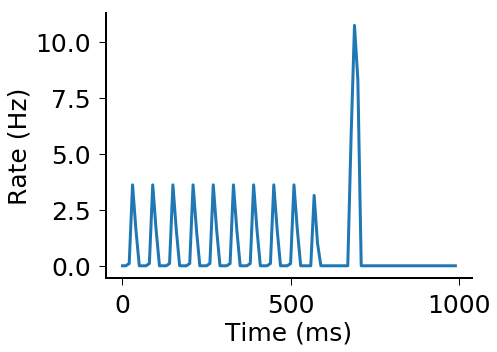

In [382]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(2)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=True, right=False,
               labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=25)




peaks = []
for i in [4]:#range( len(periods) ):
    layer = 'sequential.0'
    response_hid = tdrutils.inspect(model_n, OSR(periods[i]), insp_keys=[layer], batch_size=None, to_numpy=True, to_cpu=True, no_grad=False, verbose=False)
    #plt.plot( np.sum( response_hid['sequential.0'] , axis=(2,3))[:,1] )
    #plt.plot( np.sum( response_hid['sequential.0'] , axis=(2,3))[:,3] )
    #peaks.append(np.argmax( np.sum( response_hid['sequential.0'] , axis=(2,3))[:,1] + np.sum( response_hid['sequential.0'] , axis=(2,3))[:,3]  ))
    
    path_1 = 3*np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,1] - 100, 0 )
    path_2 = np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,3]-100,0)
    path_3 = 1*np.maximum( np.mean( response_hid['sequential.0'] , axis=(2,3))[:,5]-20,0)
    #peaks.append(np.argmax(path_1 + path_2))
    #print(np.argmax(path_1 + path_2))
    #plt.plot( path_1+path_2)
    #plt.show()
    plt.plot( 10*np.arange(len(path_1)),(path_1 + path_2 + path_3)/4, lw=3 )
    #plt.plot(path_3)
#plt.plot(10*periods,10*np.array(peaks)-600, lw=5,ls='--', c='tab:blue')


plt.xlabel('Time (ms)', size=25)
plt.ylabel('Rate (Hz)', size=25)
plt.tight_layout()
plt.savefig('./Journal_Figures/Reduced_Model_Trace.pdf')
plt.show()



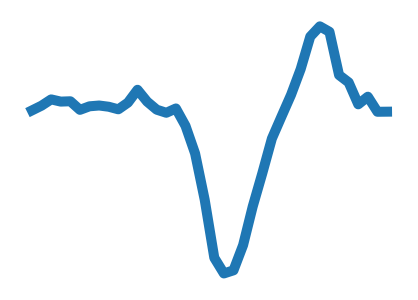

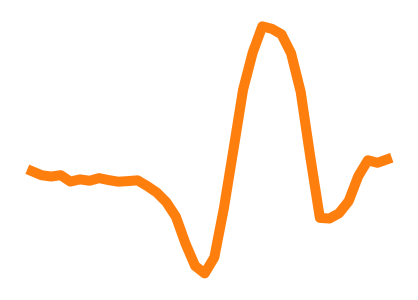

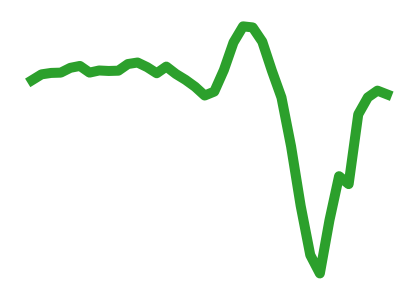

In [404]:
cells = [1,3,5]

for i in range(3):
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # Set line width of axes
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.spines["left"].set_linewidth(0)

    # Turn on/off axes, ticks, change width, labelsize
    ax.tick_params(axis="both", which="both", bottom=False, top=False,
                   labelbottom=False, left=False, right=False,
                   labelleft=False,direction='out',length=7,width=1.0,pad=8,labelsize=25)

    filter_3 = torch.sum(model_n.sequential[0].weight[cells[i]],(1,2)).cpu().detach().numpy()
    plt.plot(filter_3[2:], lw=10, c=plt.cm.tab10(i))
    #plt.ylim(-np.max(np.abs(filter_3[2:])), np.max(np.abs(filter_3[2:])))
    plt.show()